In [2]:
# cut in x-direction
sagittal = -25
# cut in y-direction
coronal = -37
# cut in z-direction
axial = -6

# prep coordinates as a list
cut_coords = [sagittal, coronal, axial]

In [3]:
from nilearn import datasets
haxby_dataset = datasets.fetch_haxby()

# print basic information on the dataset
print('First subject anatomical nifti image (3D) located is at: %s' %
      haxby_dataset.anat[0])
print('First subject functional nifti image (4D) is located at: %s' %
      haxby_dataset.func[0])
print('Labels of haxby dataset (text file) is located at: %s' %
      haxby_dataset.session_target[0])

import pandas as pd

session_target = pd.read_csv(haxby_dataset.session_target[0], sep=' ')
# labels to be used while computing student's T-test
haxby_labels = session_target['labels']

First subject anatomical nifti image (3D) located is at: /root/nilearn_data/haxby2001/subj2/anat.nii.gz
First subject functional nifti image (4D) is located at: /root/nilearn_data/haxby2001/subj2/bold.nii.gz
Labels of haxby dataset (text file) is located at: /root/nilearn_data/haxby2001/subj2/labels.txt


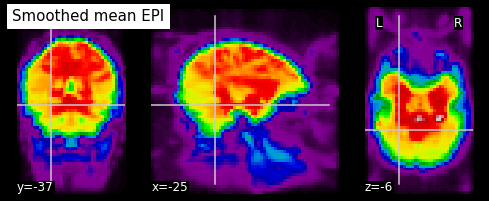

In [4]:
from nilearn import image
fmri_filename = haxby_dataset.func[0]
# smoothing: fwhm is smoothing value
# output returns Nifti image
fmri_img = image.smooth_img(fmri_filename, fwhm=6)

from nilearn.plotting import plot_epi

# compute voxel-wise mean of smoothed EPI
mean_img= image.mean_img(fmri_img)
plot_epi(mean_img, title='Smoothed mean EPI', cut_coords=cut_coords)

In [5]:
from nilearn.image import get_data

fmri_data = get_data(fmri_img)
fmri_data.shape

(40, 64, 64, 1452)

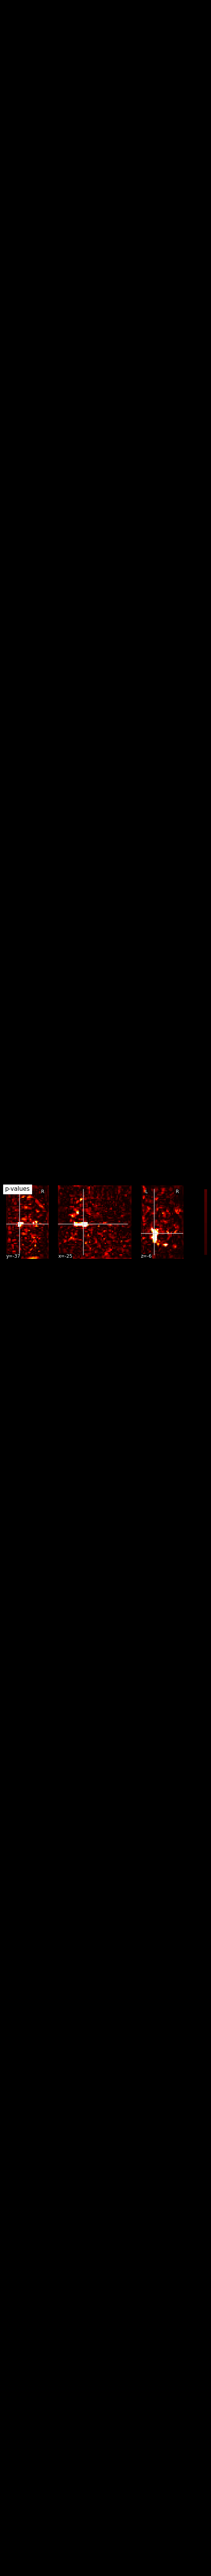

In [6]:
import numpy as np
from scipy import stats

# stats.ttest_ind returns p-values representing probability that the two time-series were drawn frmo the same distribution
# lower p-value = more discriminitave voxel in distinguishing the two conditions
_, p_values = stats.ttest_ind(fmri_data[..., haxby_labels == 'face'], fmri_data[..., haxby_labels == 'house'], axis=-1)

log_p_values = -np.log10(p_values)
log_p_values[np.isnan(log_p_values)] = 0
log_p_values[log_p_values > 10] = 10

from nilearn.plotting import plot_stat_map
from nilearn.image import new_img_like

# first image is used as a reference
log_p_values_img = new_img_like(fmri_img, log_p_values)

plot_stat_map(log_p_values_img, mean_img, title='p-values', cut_coords=cut_coords)

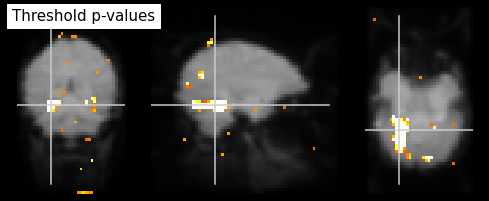

In [7]:
log_p_values[log_p_values < 5] = 0
log_p_values_img = new_img_like(fmri_img, log_p_values)

plot_stat_map(log_p_values_img, mean_img, title='Threshold p-values', annotate=False, colorbar=False, cut_coords=cut_coords)

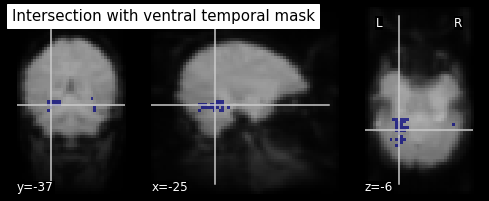

In [8]:
# self-computed mask
bin_p_values = (log_p_values != 0)
# vt mask
mask_vt_filename = haxby_dataset.mask_vt[0]

from nilearn.image import load_img
# load vt mask and convert to boolean type
vt = get_data(load_img(mask_vt_filename)).astype(bool)

# use logical and to keep only voxels that are selected in both masks
bin_p_values_and_vt = np.logical_and(bin_p_values, vt)

from nilearn.plotting import plot_roi, show

# create new imagine of binarised and intersected mask
bin_p_values_and_vt_img = new_img_like(fmri_img, bin_p_values_and_vt.astype(np.int))

plot_roi(bin_p_values_and_vt_img, mean_img, cut_coords=cut_coords, title='Intersection with ventral temporal mask')

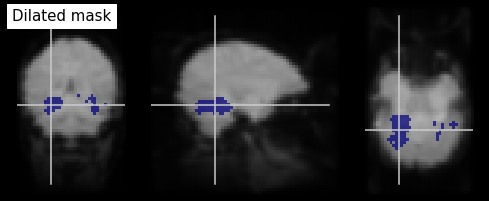

In [9]:
from scipy import ndimage

# use binarised + intersected mask data
dil_bin_p_values_and_vt = ndimage.binary_dilation(bin_p_values_and_vt)

# follow similar process
dil_bin_p_values_and_vt_img = new_img_like(fmri_img, dil_bin_p_values_and_vt.astype(np.int))
plot_roi(dil_bin_p_values_and_vt_img, mean_img, title='Dilated mask', cut_coords=cut_coords, annotate=False)

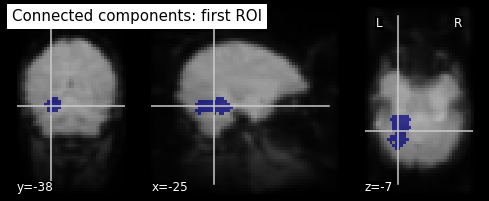

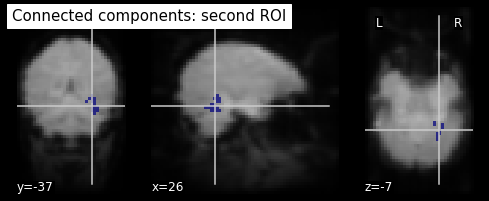

In [10]:
labels, n_labels = ndimage.label(dil_bin_p_values_and_vt)

# take first ROI data assigned as integer 1??
first_roi_data = (labels == 5).astype(np.int)
# second ROI as integer 2
second_roi_data = (labels == 3).astype(np.int)

first_roi_img = new_img_like(fmri_img, first_roi_data)
plot_roi(first_roi_img, mean_img, title='Connected components: first ROI')

second_roi_img = new_img_like(fmri_img, second_roi_data)
plot_roi(second_roi_img, mean_img, title='Connected components: second ROI')

In [11]:
from nilearn.input_data import NiftiLabelsMasker

# converting array to Nifti-like images
labels_img = new_img_like(fmri_img, labels)

# initialise masker with parameters suited for data extraction
masker = NiftiLabelsMasker(labels_img, resampling_target=None, standardize=False, detrend=False)

# prepare labels_img for data
masker.fit()

# preparing for data extraction
condition_names = haxby_labels.unique()
n_cond_img = fmri_data[..., haxby_labels == 'house'].shape[-1]
n_conds = len(condition_names)

X1, X2 = np.zeros((n_cond_img, n_conds)), np.zeros((n_cond_img, n_conds))

for i, cond in enumerate(condition_names):
    cond_maps = new_img_like(fmri_img, fmri_data[..., haxby_labels == cond][..., :n_cond_img])
    mask_data = masker.transform(cond_maps)
    X1[:, i], X2[:, i] = mask_data[:, 0], mask_data[:, 1]

condition_names[np.where(condition_names == 'scrambledpix')] = 'scrambled'

In [14]:
new_img_like(fmri_img, labels).to_filename('mask_atlas.nii.gz')

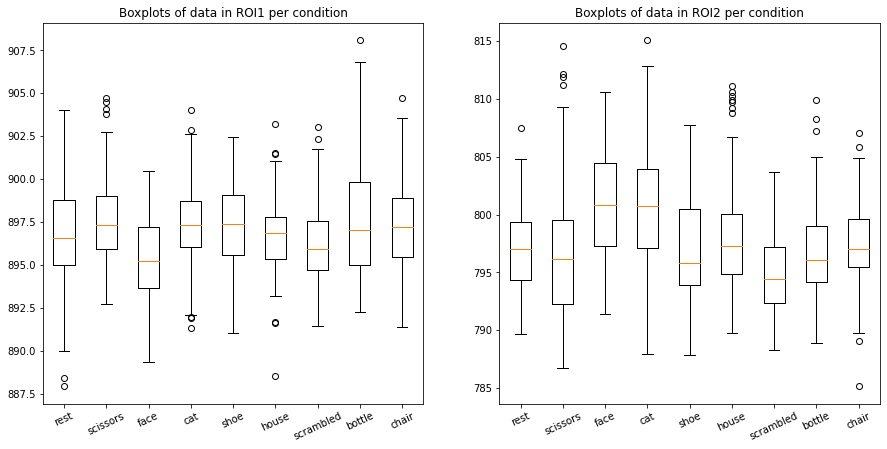

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,7))
for i in np.arange(2):
    plt.subplot(1, 2, i+1)
    plt.boxplot(X1 if i == 0 else X2)
    plt.xticks(np.arange(len(condition_names))+1, condition_names, rotation=25)
    plt.title('Boxplots of data in ROI%i per condition' % (i+1))
    
show()